# Dino v2

In [196]:
import sys
import torch

In [197]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()
backbone_model.to("cpu")

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [198]:
model = backbone_model

In [199]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torchvision.transforms as tt

images = []

#for i in range(1,5):
i = 2
#/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M2A1Slammer2__part_1.png
image = cv2.imread(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M2A1Slammer2__part_{i}.png")
#image = cv2.imread(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/test/z{i}.jpg")

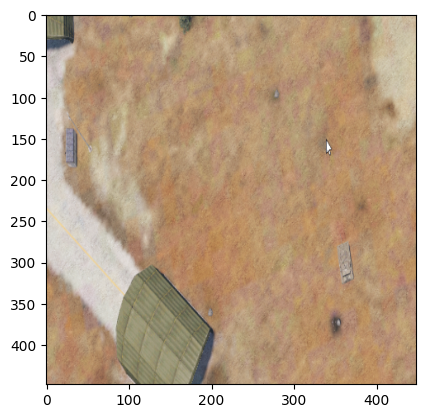

In [200]:
image = cv2.resize(image, (448,448))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')/255
images.append(image)
plt.imshow(image)

# We need to reorder the images to [batch, channel, widht, height]
# The array of loaded images is [batch, height, width, channel]
images_arr = np.stack(images)
input_tensor = torch.Tensor(np.transpose(images_arr, [0, 3, 2, 1]))

transform = tt.Compose([tt.Normalize(mean=0.5, std=0.2)])

input_tensor = transform(input_tensor)

In [201]:
input_tensor.shape

torch.Size([1, 3, 448, 448])

In [202]:
result = model.forward_features(input_tensor)

In [203]:
patch_tokens = result['x_norm_patchtokens'].detach().numpy().reshape([input_tensor.shape[0],1024,-1])

In [204]:
patch_tokens.shape

(1, 1024, 1024)

In [205]:
all_patches = patch_tokens.reshape([-1,1024])

In [206]:
all_patches.shape

(1024, 1024)

In [207]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

fg_pca = PCA(n_components=1)

all_patches = patch_tokens.reshape([-1,1024])
reduced_patches = fg_pca.fit_transform(all_patches)

In [208]:
reduced_patches.shape

(1024, 1)

In [209]:
# scale the feature to (0,1)
norm_patches = minmax_scale(reduced_patches)

In [210]:
# reshape the feature value to the original image size
image_norm_patches = norm_patches.reshape([1,1024])

In [211]:
image_norm_patches.shape

(1, 1024)

In [212]:
image_patches = image_norm_patches

In [213]:
masks=[]
plt.figure(figsize=(10,10))

mask = (image_patches < 0.2).ravel()

#image_patches[np.logical_not(mask)] = 0

<Figure size 1000x1000 with 0 Axes>

In [214]:
image_patches.shape

(1, 1024)

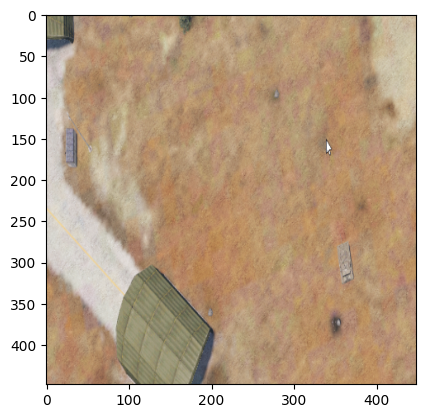

In [215]:
images[0].shape

plt.imshow(images[0])

In [216]:
image_patches.reshape([32,-1]).T.shape

(32, 32)

In [217]:
image_patches[0]

array([0.09724224, 0.12572742, 0.08217663, ..., 0.8844294 , 0.24179205,
       0.20353226], dtype=float32)

In [218]:
image_patches.shape

(1, 1024)

In [219]:
image_patches.reshape([32,-1]).shape

(32, 32)

In [220]:
mask = (image_patches < 0.3).ravel()

In [221]:
mask.shape

(1024,)

In [222]:
image_patches_copy = image_patches[0].copy()

In [223]:
mask.shape

(1024,)

In [224]:
image_patches_copy.shape

(1024,)

In [225]:
image_patches_copy[np.logical_not(mask)] = 0

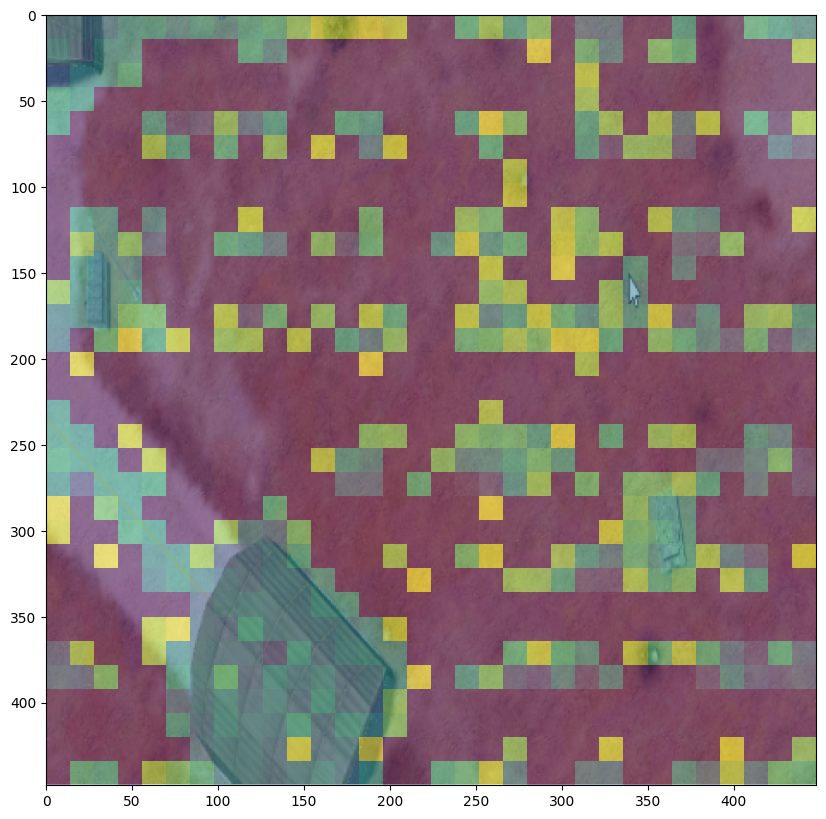

In [226]:
plt.figure(figsize=(10,10))


plt.imshow(images[0])
#plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)
plt.imshow(image_patches_copy.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)

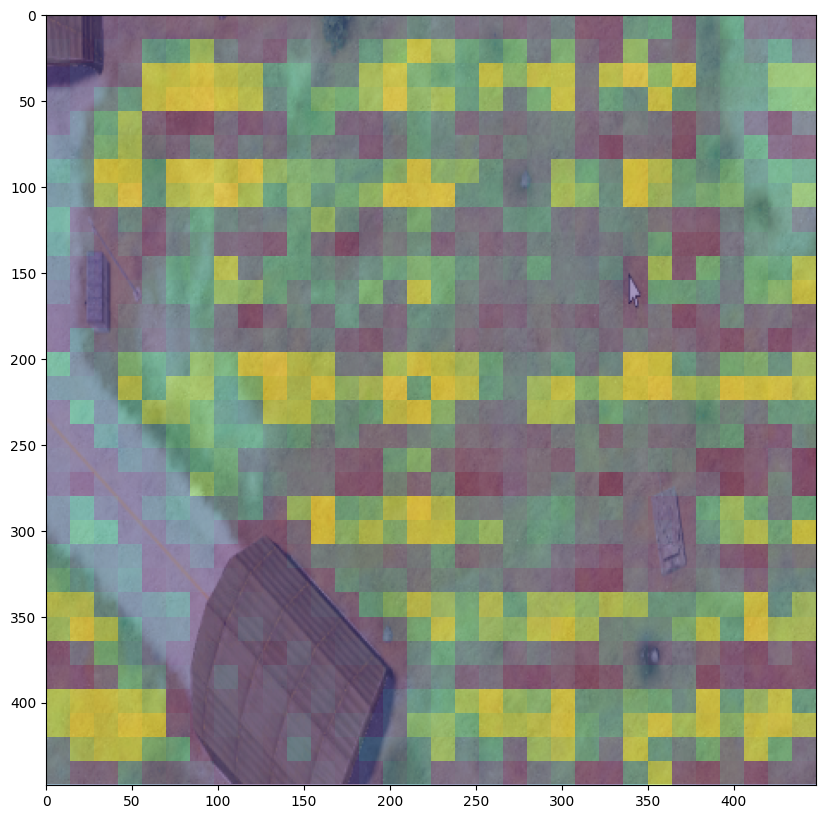

In [227]:
#masks=[]
plt.figure(figsize=(10,10))

mask = (image_patches < 0.5).ravel()

#image_patches[0][np.logical_not(mask)] = 0


plt.imshow(images[0])
#plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)
plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)

In [228]:
# scale the feature to (0,1)
norm_patches = minmax_scale(reduced_patches)

# reshape the feature value to the original image size
image_norm_patches = norm_patches.reshape([4,1024])

for i in range(4):
    image_patches = image_norm_patches[i,:]

    # choose a threshold to segment the foreground
    mask = (image_patches < 0.2).ravel()
    masks.append(mask)

    image_patches[np.logical_not(mask)] = 0

    plt.subplot(221+i)
    plt.imshow(images[i])
    plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)

ValueError: cannot reshape array of size 1024 into shape (4,1024)